# Instruction for running
#### 1. Please keep all files in the same directory/same folder as of notebook. There is no need to create sub folder or change path.
#### 2. I have used two embeddings, one is Word2Vec, and another is GloVe. Word2Vec was used to augment the data, and I am providing the augmented data in a csv file, and also commented the augmenting code so that you don't have to run it again. I kept the code as a proof of how I augmented the data
#### 3. For GloVe I have used glove.6B.200d.txt . Please use the .txt format for that embedding, or else it won't run. Keep this embedding in the same folders of the notebook, again no need to create any foldersers

In [1]:
!pip install tensorflow
!pip install nlpaug
!pip install neattext
!pip install transformers
!pip install seaborn
!pip install pandas
!pip install scikit-learn
!pip install scipy==1.10.1
!pip install nltk
!pip install gensim
!pip install wordcloud

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import neattext.functions as nfx
from keras import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences, to_categorical
from keras.layers import Embedding, Dense, LSTM, Bidirectional, GlobalMaxPooling1D, Input, Dropout, Flatten
from keras import models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import SimpleRNN, GRU, RNN
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [82]:
max_words = 100

In [83]:
dataset_path = '712_train_all_tasks.csv'

In [84]:
df1 = pd.read_csv(dataset_path)

In [85]:
df = df1

In [86]:
df.columns

Index(['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'], dtype='object')

In [87]:
df['label_sexist'].value_counts()

label_sexist
not sexist    10602
sexist         3398
Name: count, dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_12444\1397291020.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette=colors)


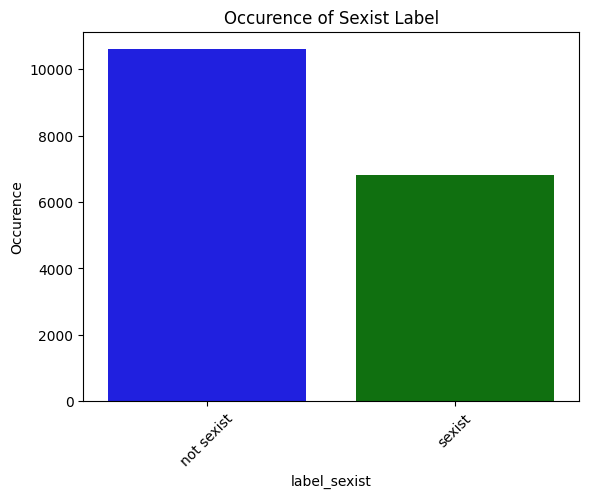

In [171]:
value_counts = df['label_sexist'].value_counts()

# Define colors for the bars
colors = ['blue', 'green']  # You can specify colors for each category

# Create a count plot with specified colors
sns.barplot(x=value_counts.index, y=value_counts.values, palette=colors)
plt.xticks(rotation=45)
plt.ylabel('Occurence')
plt.title('Occurence of Sexist Label')
plt.show()

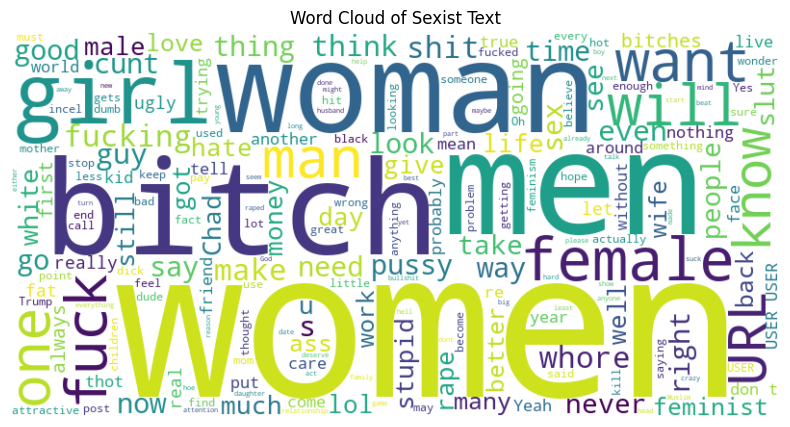

In [89]:
sexist_text = " ".join(df[df['label_sexist'] == 'sexist']['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sexist_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Sexist Text')
plt.axis('off')
plt.show()

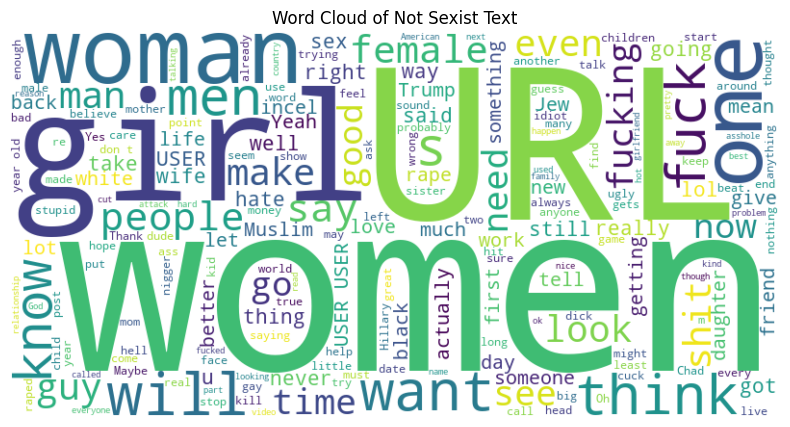

In [90]:
sexist_text = " ".join(df[df['label_sexist'] == 'not sexist']['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sexist_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Not Sexist Text')
plt.axis('off')
plt.show()

In [91]:
df.drop(['label_vector', 'rewire_id', 'label_category'], axis=1, inplace=True)

In [92]:
df.columns

Index(['text', 'label_sexist'], dtype='object')

# Data Augmentation
Augmenting dataset with help of word2vec, but no need to uncomment it as I have already saved the augmented data in a csv file (augmentation takes a long time to run). But I provided code so that if you want to check how I generated the data. 

In [93]:
# from nlpaug.util.file.download import DownloadUtil
# DownloadUtil.download_word2vec(dest_dir = '.')
# # # Possible values are ‘wiki-news-300d-1M’, ‘wiki-news-300d-1M-subword’, ‘crawl-300d-2M’ and ‘crawl-300d-2M-subword’
# # DownloadUtil.download_fasttext(dest_dir = '.', model_name = 'crawl-300d-2M')
# # # Possible values are ‘glove.6B’, ‘glove.42B.300d’, ‘glove.840B.300d’ and ‘glove.twitter.27B’
# # DownloadUtil.download_glove(dest_dir = '.', model_name = 'glove.6B')

In [94]:

# # Initialize the augmenter with model "fasttext"
# aug = naw.WordEmbsAug(
#   # You can choose from "word2vec", "glove", or "fasttext" 
#   model_type = 'word2vec', 
#   # Note: check your "content" path to find out specific model names
#   model_path = 'GoogleNews-vectors-negative300.bin',
#   # You may also choose "insert"
#   action = "substitute")

In [95]:
# augmented_data = []
# sexist_data = df[df['label_sexist'] == 'sexist']
# for i, text in enumerate(sexist_data['text']):
#     augmented_text = aug.augment(text)
#     # print(i, augmented_text)
#     augmented_data.append({'text': augmented_text, 'label_sexist': 'sexist'})

# augmented_df = pd.DataFrame(augmented_data)

In [96]:
# augmented_df.to_csv('augmented_task_1.csv', index=False)

In [97]:
augmented_df = pd.read_csv('augmented_task_1.csv')

In [98]:
# Concatenate original and augmented data
df = pd.concat([df, augmented_df], ignore_index=True)

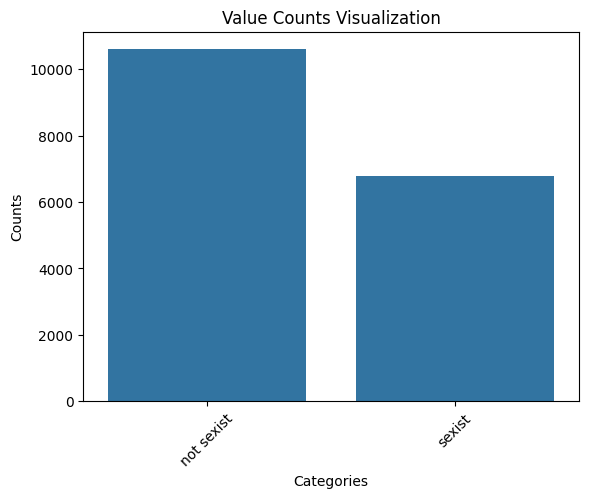

In [99]:
value_counts = df['label_sexist'].value_counts()

# Create a count plot
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Value Counts Visualization')
plt.show()

In [100]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in text:
        sent = str(sent)
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [101]:
# embeddings = "50"
embeddings = "200"

In [102]:
df2 = pd.read_csv('glove.6B.'+ embeddings + 'd.txt', sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in df2.T.items()}

In [103]:
with open('glove.6B.' + embeddings+ 'd.pkl', 'wb') as fp:
    pickle.dump(glove, fp)
with open('glove.6B.' + embeddings+ 'd.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)
pretrained_file_name = 'glove.6B.' + embeddings+ 'd.pkl'
with open(pretrained_file_name, 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [104]:
df

,text,label_sexist
0,"Damn, this writing was pretty chaotic",not sexist
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist
2,How the FUCK is this woman still an MP!!!???,not sexist
3,Understand. Know you're right. At same time I ...,not sexist
4,Surprized they didn't stop and rape some women,not sexist
...,...,...
17393,['AThe Democrat with signal eyeglasses. Tthere...,sexist
17394,"[""“ Naturally ’ Montana_Jeannette_Rankin **** ...",sexist
17395,"[""Never forget, it ' Germanyâ_€_™ always the m...",sexist
17396,['lol german revolves_around on boatload next ...,sexist


In [105]:
def plot_training_curve(history, st):
    st = 'Training Curve for ' + st
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(st)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [106]:
def plot_training_curve_acc(history, st):
    st = 'Training Curve for ' + st
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title( st)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [107]:
txt, txt_length=clean_text(df['text'])

In [108]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(txt)

In [109]:
# Vocabulary size
vocab_size = len(tokenizer.word_index)
embedding_matrix=np.zeros((vocab_size+1,int(embeddings)), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [110]:
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

In [111]:
mapping = {'not sexist': 1, 'sexist': 0}
train_output = np.array([mapping[label] for label in train_data['label_sexist']])
test_output = np.array([mapping[label] for label in test_data['label_sexist']])

In [112]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

In [113]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=max_words)

test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=max_words)

# Neural Network Models

Set Number of epochs for all models here

In [142]:
epoch = 15

# Fully Connected Neural Network

In [143]:
model=Sequential()
model.add(Input(shape=(max_words,)))
model.add(Embedding(vocab_size + 1, int(embeddings), weights=[embedding_matrix], trainable=False ))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [144]:
history  =model.fit(train_text_pad, train_output, epochs=epoch, validation_data = (test_text_pad,  test_output) )

Epoch 1/15
408/408 [==============================] - 21s 49ms/step - loss: 0.5944 - accuracy: 0.6767 - val_loss: 0.5623 - val_accuracy: 0.7110
Epoch 2/15
408/408 [==============================] - 12s 29ms/step - loss: 0.4387 - accuracy: 0.7943 - val_loss: 0.5558 - val_accuracy: 0.7228
Epoch 3/15
408/408 [==============================] - 12s 29ms/step - loss: 0.2603 - accuracy: 0.8939 - val_loss: 0.6311 - val_accuracy: 0.7340
Epoch 4/15
408/408 [==============================] - 11s 28ms/step - loss: 0.1324 - accuracy: 0.9488 - val_loss: 0.8942 - val_accuracy: 0.7324
Epoch 5/15
408/408 [==============================] - 11s 27ms/step - loss: 0.0938 - accuracy: 0.9647 - val_loss: 0.9865 - val_accuracy: 0.7200
Epoch 6/15
408/408 [==============================] - 11s 28ms/step - loss: 0.0791 - accuracy: 0.9741 - val_loss: 1.0592 - val_accuracy: 0.7368
Epoch 7/15
408/408 [==============================] - 12s 30ms/step - loss: 0.0586 - accuracy: 0.9787 - val_loss: 1.2500 - val_accuracy:

In [145]:
loss, accuracy = model.evaluate(test_text_pad,  test_output, verbose=2)
print(accuracy)
print(loss)

136/136 - 1s - loss: 1.6358 - accuracy: 0.7310 - 599ms/epoch - 4ms/step
0.7310344576835632
1.635782241821289


In [146]:
predictions = model.predict(test_text_pad)
predictions_binary = (predictions > 0.5).astype(int)
report = classification_report(test_output, predictions_binary)
print(report)

136/136 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1711
           1       0.77      0.80      0.78      2639

    accuracy                           0.73      4350
   macro avg       0.72      0.71      0.71      4350
weighted avg       0.73      0.73      0.73      4350



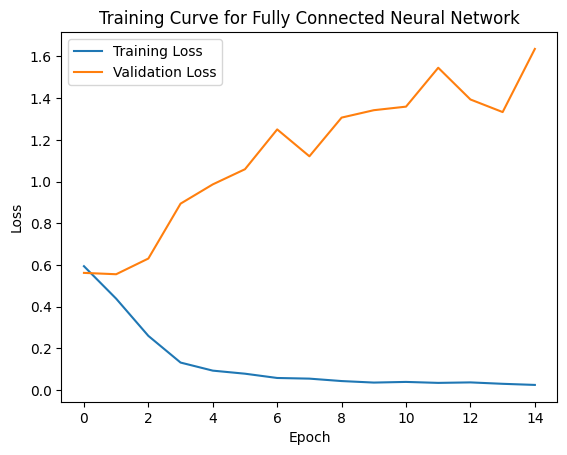

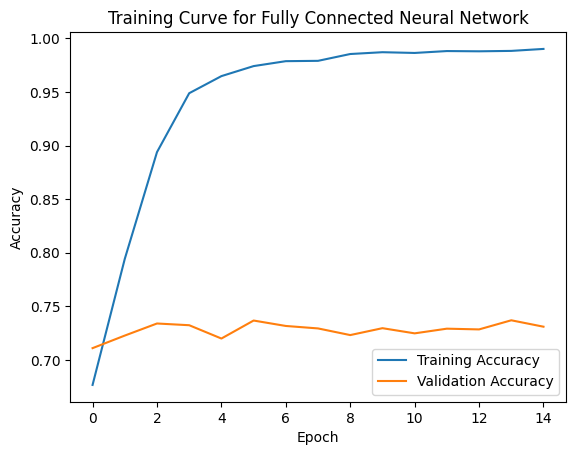

In [147]:
plot_training_curve(history, 'Fully Connected Neural Network')
plot_training_curve_acc(history, 'Fully Connected Neural Network')

In [148]:
m1 = model

# Bidirectional LSTM

In [149]:
model=Sequential()
model.add(Input(shape=(max_words,)))
model.add(Embedding(vocab_size+1,int(embeddings),weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [150]:
history  = model.fit(train_text_pad, train_output, epochs=epoch, validation_data = (test_text_pad,  test_output) )

Epoch 1/15
408/408 [==============================] - 131s 310ms/step - loss: 0.5092 - accuracy: 0.7462 - val_loss: 0.4386 - val_accuracy: 0.7959
Epoch 2/15
408/408 [==============================] - 114s 280ms/step - loss: 0.4056 - accuracy: 0.8135 - val_loss: 0.4187 - val_accuracy: 0.8007
Epoch 3/15
408/408 [==============================] - 118s 289ms/step - loss: 0.3623 - accuracy: 0.8371 - val_loss: 0.3956 - val_accuracy: 0.8216
Epoch 4/15
408/408 [==============================] - 109s 268ms/step - loss: 0.3032 - accuracy: 0.8661 - val_loss: 0.4556 - val_accuracy: 0.8048
Epoch 5/15
408/408 [==============================] - 106s 260ms/step - loss: 0.2533 - accuracy: 0.8900 - val_loss: 0.4054 - val_accuracy: 0.8338
Epoch 6/15
408/408 [==============================] - 106s 260ms/step - loss: 0.2158 - accuracy: 0.9069 - val_loss: 0.5049 - val_accuracy: 0.8230
Epoch 7/15
408/408 [==============================] - 112s 273ms/step - loss: 0.1666 - accuracy: 0.9297 - val_loss: 0.4817 -

In [151]:
loss, accuracy = model.evaluate(test_text_pad,  test_output, verbose=2)
print(accuracy)
print(loss)

136/136 - 67s - loss: 0.7052 - accuracy: 0.8223 - 67s/epoch - 495ms/step
0.8222988247871399
0.7051917910575867


In [152]:
predictions = model.predict(test_text_pad)
predictions_binary = (predictions > 0.5).astype(int)
report = classification_report(test_output, predictions_binary)
print(report)

136/136 [==============================] - 71s 511ms/step
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1711
           1       0.87      0.84      0.85      2639

    accuracy                           0.82      4350
   macro avg       0.81      0.82      0.82      4350
weighted avg       0.82      0.82      0.82      4350



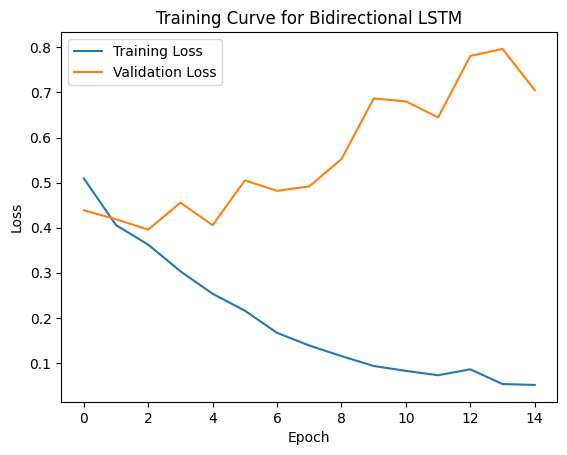

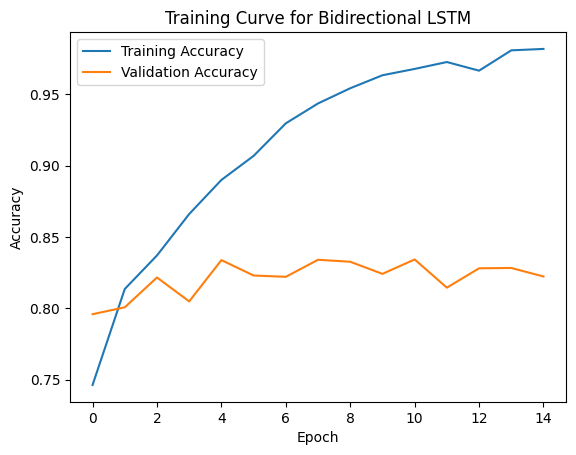

In [153]:
plot_training_curve(history, 'Bidirectional LSTM')
plot_training_curve_acc(history, 'Bidirectional LSTM')

In [154]:
m2 = model

# Bidirectional SimpleRNN

In [155]:
model=Sequential()
model.add(Input(shape=(max_words,)))
model.add(Embedding(vocab_size+1,int(embeddings),weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(SimpleRNN(256,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [156]:
history  = model.fit(train_text_pad, train_output, epochs=epoch, validation_data = (test_text_pad,  test_output) )

Epoch 1/15
408/408 [==============================] - 303s 731ms/step - loss: 0.6701 - accuracy: 0.6058 - val_loss: 0.6718 - val_accuracy: 0.6067
Epoch 2/15
408/408 [==============================] - 211s 518ms/step - loss: 0.6211 - accuracy: 0.6641 - val_loss: 0.6137 - val_accuracy: 0.6740
Epoch 3/15
408/408 [==============================] - 298s 730ms/step - loss: 0.5354 - accuracy: 0.7329 - val_loss: 0.5147 - val_accuracy: 0.7476
Epoch 4/15
408/408 [==============================] - 301s 736ms/step - loss: 0.5092 - accuracy: 0.7547 - val_loss: 0.5054 - val_accuracy: 0.7405
Epoch 5/15
408/408 [==============================] - 288s 707ms/step - loss: 0.4854 - accuracy: 0.7636 - val_loss: 0.4773 - val_accuracy: 0.7724
Epoch 6/15
408/408 [==============================] - 193s 474ms/step - loss: 0.4651 - accuracy: 0.7790 - val_loss: 0.4766 - val_accuracy: 0.7685
Epoch 7/15
408/408 [==============================] - 278s 683ms/step - loss: 0.4407 - accuracy: 0.7968 - val_loss: 0.4494 -

In [157]:
loss, accuracy = model.evaluate(test_text_pad,  test_output, verbose=2)
print(accuracy)
print(loss)

136/136 - 3s - loss: 0.4302 - accuracy: 0.8071 - 3s/epoch - 26ms/step
0.8071264624595642
0.43015429377555847


In [158]:
predictions = model.predict(test_text_pad)
predictions_binary = (predictions > 0.5).astype(int)
report = classification_report(test_output, predictions_binary)
print(report)

136/136 [==============================] - 4s 25ms/step
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1711
           1       0.82      0.87      0.85      2639

    accuracy                           0.81      4350
   macro avg       0.80      0.79      0.79      4350
weighted avg       0.81      0.81      0.81      4350



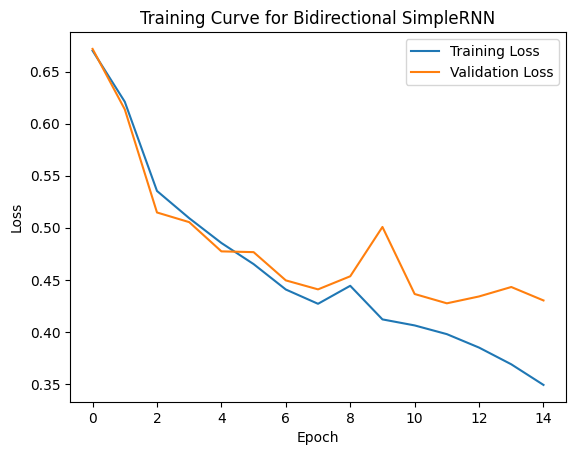

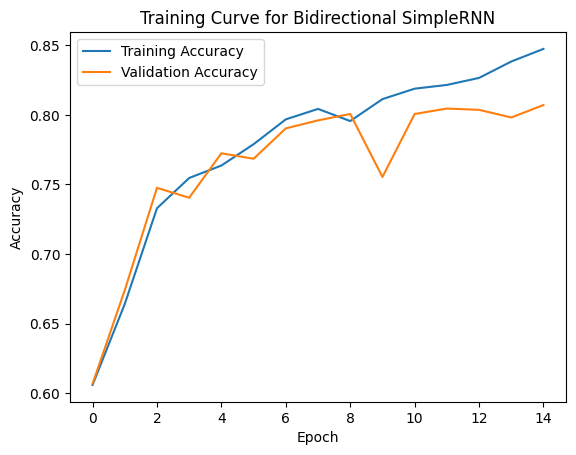

In [159]:
plot_training_curve(history, 'Bidirectional SimpleRNN')
plot_training_curve_acc(history, 'Bidirectional SimpleRNN' )

In [160]:
m3 = model

# Bidirectional GRU

In [161]:
model=Sequential()
model.add(Input(shape=(max_words,)))
model.add(Embedding(vocab_size+1,int(embeddings),weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(GRU(250,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [162]:
history  = model.fit(train_text_pad, train_output, epochs=epoch, validation_data = (test_text_pad,  test_output) )

Epoch 1/15
408/408 [==============================] - 61s 139ms/step - loss: 0.5171 - accuracy: 0.7454 - val_loss: 0.4460 - val_accuracy: 0.7913
Epoch 2/15
408/408 [==============================] - 56s 138ms/step - loss: 0.3973 - accuracy: 0.8191 - val_loss: 0.4281 - val_accuracy: 0.7963
Epoch 3/15
408/408 [==============================] - 57s 139ms/step - loss: 0.3468 - accuracy: 0.8488 - val_loss: 0.4305 - val_accuracy: 0.7906
Epoch 4/15
408/408 [==============================] - 56s 138ms/step - loss: 0.3149 - accuracy: 0.8630 - val_loss: 0.3898 - val_accuracy: 0.8262
Epoch 5/15
408/408 [==============================] - 57s 140ms/step - loss: 0.2509 - accuracy: 0.8950 - val_loss: 0.4514 - val_accuracy: 0.8308
Epoch 6/15
408/408 [==============================] - 56s 138ms/step - loss: 0.2088 - accuracy: 0.9114 - val_loss: 0.4923 - val_accuracy: 0.8129
Epoch 7/15
408/408 [==============================] - 57s 139ms/step - loss: 0.1732 - accuracy: 0.9299 - val_loss: 0.4463 - val_ac

In [163]:
loss, accuracy = model.evaluate(test_text_pad,  test_output, verbose=2)
print(accuracy)
print(loss)

136/136 - 6s - loss: 0.8895 - accuracy: 0.8276 - 6s/epoch - 41ms/step
0.8275862336158752
0.8894569873809814


In [164]:
predictions = model.predict(test_text_pad)
predictions_binary = (predictions > 0.5).astype(int)
report = classification_report(test_output, predictions_binary)
print(report)

136/136 [==============================] - 6s 41ms/step
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1711
           1       0.85      0.87      0.86      2639

    accuracy                           0.83      4350
   macro avg       0.82      0.82      0.82      4350
weighted avg       0.83      0.83      0.83      4350



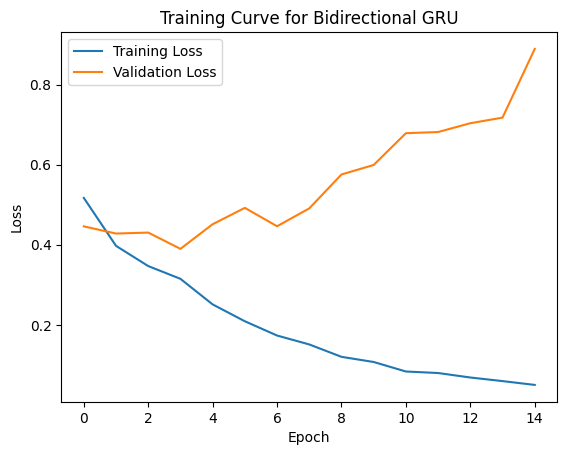

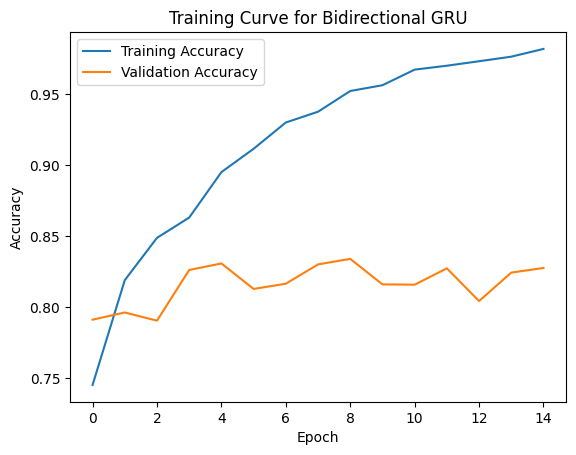

In [165]:
plot_training_curve(history, 'Bidirectional GRU')
plot_training_curve_acc(history, 'Bidirectional GRU' )

In [166]:
m4 = model

# BERT

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')  # Adjust num_labels based on your task

# Compile the model with appropriate loss function
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Fine-tune the BERT model
model.fit(train_text_pad, train_output, batch_size=32, epochs=5)

In [ ]:
# Make predictions
predictions = model.predict(test_text_pad)

In [ ]:
# Convert predictions to binary labels
predictions_binary = (predictions > 0.5).astype(int)

# Assuming your true labels are in 'test_output'

# Generate classification report
report = classification_report(test_output, predictions_binary)

print(report)